## Training Neural Network on mL96 Forcing 
- Here we train a single layer feedforward network on the forcing for the lorenz 96 equations to find the ground truth

By: Rebecca Gjini Date: 03/10/2025

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from scipy.spatial.distance import cdist

In [2]:
#Define neural network object
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)
    
def random_sin(nx, B, A, omega, gamma): 
    return B + A*np.sin(omega*((4*np.pi*np.arange(0, nx, 1))/nx) + gamma) 


In [ ]:
file_path = "main/l96/nn_mp_strong/sinusoid_samples/"
# Setup 
nx = 100
x = np.linspace(-5.0, 5.0, nx).reshape(-1, 1)

# Network parameters
input_dim = 1
hidden_dim = 20
output_dim = 1

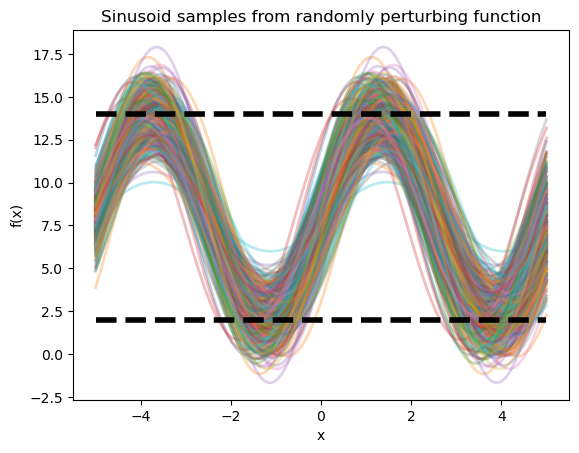

In [4]:
scale = 0.02
plt.figure()
for jj in range(0, 500): 
    np.random.seed(jj)
    A = 1 + 10*scale*np.random.normal(0, 1)
    B = scale*np.random.normal(0, 1)
    omega = 1 + scale*np.random.normal(0, 1)
    gamma = 10*scale*np.random.normal(0, 1)
    y = random_sin(nx, B, A, omega, gamma)
    plt.plot(x, 8 + 6*y, linewidth=2, alpha = 0.3) #color = 'purple',
plt.plot(x, 14*np.ones_like(y), linewidth = 4, linestyle = "dashed", color = "black")
plt.plot(x, 2*np.ones_like(y), linewidth = 4, linestyle = "dashed", color = "black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Sinusoid samples from randomly perturbing function")
plt.show()

In [ ]:
# Generate GP samples and train a NN on them to save weights and biases
num_samples = 500

for ii in range(250, num_samples): 
    np.random.seed(ii)
    A = 1 + 10*scale*np.random.normal(0, 1)
    B = scale*np.random.normal(0, 1)
    omega = 1 + scale*np.random.normal(0, 1)
    gamma = 10*scale*np.random.normal(0, 1)
    y = random_sin(nx, B, A, omega, gamma)

    # Convert to PyTorch tensors
    x_train = torch.tensor(x, dtype=torch.float32)
    y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    model = FeedforwardNN(input_dim, hidden_dim, output_dim)
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.03, max_iter=10, history_size=20)
    epochs = 1100

    def closure():
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        return loss

    # Training loop
    for epoch in range(epochs):  # Number of LBFGS steps
        loss = optimizer.step(closure)
        # if epoch % 50 == 0:
            # print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}")

    print("Training complete for random num:" + f"{ii}")

    # Generate test data
    x_test = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Predict using trained model
    y_test_pred = model(x_test_tensor).detach().numpy()

    # Plot the GP sample and NN approximation
    plt.figure(figsize=(8, 5))
    plt.plot(x, 8 + 6*y, label="True GP Sample", linewidth=2, linestyle="dashed")
    plt.plot(x_test, 8 + 6*y_test_pred, label="NN Approximation", linewidth=2)
    plt.scatter(x, 8 + 6*y, color='red', s=10, label="Training Points")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Random Sin Sample vs. Neural Network Approximation")
    plt.show()

    # Extract and flatten all parameters
    params = [param.detach().numpy().flatten() for param in model.parameters()]
    flattened_params = np.concatenate(params)

    np.savetxt(file_path + f"sample_{ii}.txt", flattened_params, delimiter = ",")